In [2]:
# imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import dask.array as da
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask

In [ ]:
# data paths
modis = 'E:/modis_2001_2024/npp_steppe/npp_ecoregions'  # Folder with MODIS NPP data with gaps, clipped by ecoregions
modis_filled = 'E:/modis_2001_2024/npp_steppe'  # Folder with MODIS NPP gap-filled

steppe = 'E:/ecoregions_palearctic_steppe/ecoregions_palearctic_steppe.shp'  # shp-file with steppe ecoregions
steppe_filtered = 'E:/ecoregions_palearctic_steppe/ecoregions_steppe_filtered.shp' # filtered shp-file with steppe ecoregions (without ecoregions, where NPP nodata < 40%)
ecoregions = 'E:/ecoregions_palearctic_steppe/ecoregions.tif' # rastered polygons of ecoregions

In [ ]:
# loading shp and grouping by ecoregions
gdf = gpd.read_file(steppe)
gdf = gdf.dissolve(by='ECO_NAME').reset_index()

# adding rasters with npp data
rasters_npp = sorted(glob.glob(os.path.join(modis, '*.tif')))
print(f'{len(rasters_npp)} npp files')
rasters_npp_filled = sorted(glob.glob(os.path.join(modis_filled, '*.tif')))
print(f'{len(rasters_npp_filled)} npp_filled files')

24 npp files
24 npp_filled files


In [4]:
# NaN (values > 32760) stata (2024 year)
results = []

npp_2024 = [raster for raster in rasters_npp_filled if int(raster.split('/')[-1][-15:-11]) == 2024]
print("Selected rasters for 2024:", npp_2024)

for id, row in gdf.iterrows():
    ecoregion = row['ECO_NAME']  # ecoregion name
    geom = [row.geometry]  # grouped polygon geometry

    for raster_npp_filled in npp_2024:
        print(f"Processing {raster_npp_filled} for ecoregion {ecoregion}")
        try:
            with rasterio.open(raster_npp_filled) as raster:
                nodata_value = raster.nodata
                out_image, _ = rasterio.mask.mask(raster, geom, crop=True, nodata=nodata_value)
                out_image = out_image[0].astype(np.float32)
                out_image[out_image == nodata_value] = np.nan

                filledgaps_mask = out_image > 32760
                total_pixels = np.sum(~np.isnan(out_image))
                filledgaps_pixels = np.sum(filledgaps_mask)
                filledgaps_percent = (filledgaps_pixels / total_pixels) * 100

                results.append({
                    'ecoregion': ecoregion,
                    'year': 2024,
                    'total_pixels': total_pixels,
                    'filledgaps_pixels': filledgaps_pixels,
                    'filledgaps_percent': filledgaps_percent
                })
                print(f'{raster_npp_filled} processed for ecoregion {ecoregion}')

        except Exception as e:
            print(f'Error with {raster_npp_filled} for ecoregion {ecoregion}: {e}')

df_results = pd.DataFrame(results)
df_results.to_csv("npp_ecoregions_filledgaps_data_2024.csv", index=False)
print(df_results)

Selected rasters for 2024: ['E:/modis_2001_2024/npp_steppe\\npp2024_steppe.tif']
Processing E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif for ecoregion Alai-Western Tian Shan steppe
E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif processed for ecoregion Alai-Western Tian Shan steppe
Processing E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif for ecoregion Altai montane forest and forest steppe
E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif processed for ecoregion Altai montane forest and forest steppe
Processing E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif for ecoregion Altai steppe and semi-desert
E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif processed for ecoregion Altai steppe and semi-desert
Processing E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif for ecoregion Amur meadow steppe
E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif processed for ecoregion Amur meadow steppe
Processing E:/modis_2001_2024/npp_steppe\npp2024_steppe.tif for ecoregion Azerbaijan shrub desert

In [ ]:
print(df_results.sort_values(by='filledgaps_percent', ascending=False).head(5))
threshold = 40
df_filtered = df_results[df_results['filledgaps_percent'] <= threshold]
gdf_filtered = gdf.loc[gdf['ECO_NAME'].isin(df_filtered['ecoregion'])]

gdf_filtered.to_file(steppe_filtered) # saving filtered shp-file without ecoregions, where NPP nodata < 40%
print(f'Filtered shp: {steppe_filtered}')

                                       ecoregion  year  total_pixels  \
35      Tarim Basin deciduous forests and steppe  2024        425800   
18  Karakoram-West Tibetan Plateau alpine steppe  2024        993418   
23                            Middle East steppe  2024        925422   
15               Gobi Lakes Valley desert steppe  2024       1321366   
34                 Sulaiman Range alpine meadows  2024        152870   

    filledgaps_pixels  filledgaps_percent  
35             381092           89.500235  
18             830178           83.567844  
23             608377           65.740495  
15             722641           54.688936  
34              75138           49.151567  
Filtered shp: E:/ecoregions_palearctic_steppe/ecoregions_steppe_filtered.shp


c:\Users\varva\venvs\global_env\venv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 224741024877 of field Shape_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\varva\venvs\global_env\venv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 7361902580.31999969 of field Shape_Area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\varva\venvs\global_env\venv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 189239580314 of field Shape_Area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\varva\venvs\global_env\venv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 124914023931 of field Shape_Area of feature 3 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\varva\ve

In [ ]:
# zonal statistics 
sheets = pd.read_excel('E:\diplom\zonal_stat.xls', sheet_name=None, index_col='ZONE_CODE') # statistics for each year from analysis in ArcGIS
columns = ['ECO_NAME', 'MIN', 'MAX', 'MEAN', 'STD', 'MEDIAN', 'PCT5', 'PCT95']
years = list(range(2001, 2025))
zonal_stat = None 

for i, (sheet_name, df) in enumerate(sheets.items()):
    year = years[i]
    df_selected = df[columns]

    if i == 0:
        df_renamed = df_selected.rename(columns={col: f"{col}_{year}" for col in df_selected.columns if col != 'ECO_NAME'}) # combining all years to one table
    else:
        df_renamed = df_selected.drop(columns='ECO_NAME', errors='ignore').rename(columns={col: f"{col}_{year}" for col in df_selected.columns})

    if zonal_stat is None:
        zonal_stat = df_renamed
    else:
        zonal_stat = pd.concat([zonal_stat, df_renamed], axis=1)

print('zonal stat is combined')

zonal stat is combined


In [3]:
zonal_stat.to_excel('E:\diplom\zonal_stat_combined.xlsx')
zonal_stat.head()

,ECO_NAME,MIN_2001,MAX_2001,MEAN_2001,STD_2001,MEDIAN_2001,PCT5_2001,PCT95_2001,MIN_2002,MAX_2002,...,MEDIAN_2023,PCT5_2023,PCT95_2023,MIN_2024,MAX_2024,MEAN_2024,STD_2024,MEDIAN_2024,PCT5_2024,PCT95_2024
ZONE_CODE,,,,,,,,,,,,,,,,,,,,,
1,Khangai Mountains alpine meadow,0.0205,0.4831,0.180304,0.054590,0.1785,0.0950,0.2724,0.0179,0.4409,...,0.2013,0.1043,0.3134,0.0338,0.6586,0.246838,0.069527,0.2435,0.1358,0.3626
2,Selenge-Orkhon forest steppe,0.0259,0.6557,0.261548,0.087541,0.2544,0.1325,0.4217,0.0234,0.6069,...,0.2958,0.1508,0.5203,0.0313,0.7643,0.335870,0.107513,0.3278,0.1775,0.5173
3,Kopet Dag woodlands and forest steppe,0.0001,0.3917,0.077079,0.037758,0.0703,0.0312,0.1434,0.0001,0.4843,...,0.0719,0.0333,0.1710,0.0010,0.5278,0.107015,0.057150,0.0931,0.0416,0.2103
4,Eastern Himalayan alpine shrub and meadows,0.0001,1.9256,0.221412,0.273761,0.1079,0.0286,0.9002,0.0001,1.9849,...,0.1196,0.0310,0.8547,0.0008,1.8737,0.237442,0.251233,0.1387,0.0377,0.8216
5,Great Lakes Basin desert steppe,0.0132,0.6841,0.120841,0.083049,0.0917,0.0483,0.3058,0.0157,0.6101,...,0.0994,0.0536,0.3112,0.0165,0.7111,0.155284,0.095780,0.1207,0.0626,0.3685


In [10]:
import matplotlib.pyplot as plt

C:\Users\varva\AppData\Local\Temp\ipykernel_2420\356861498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']


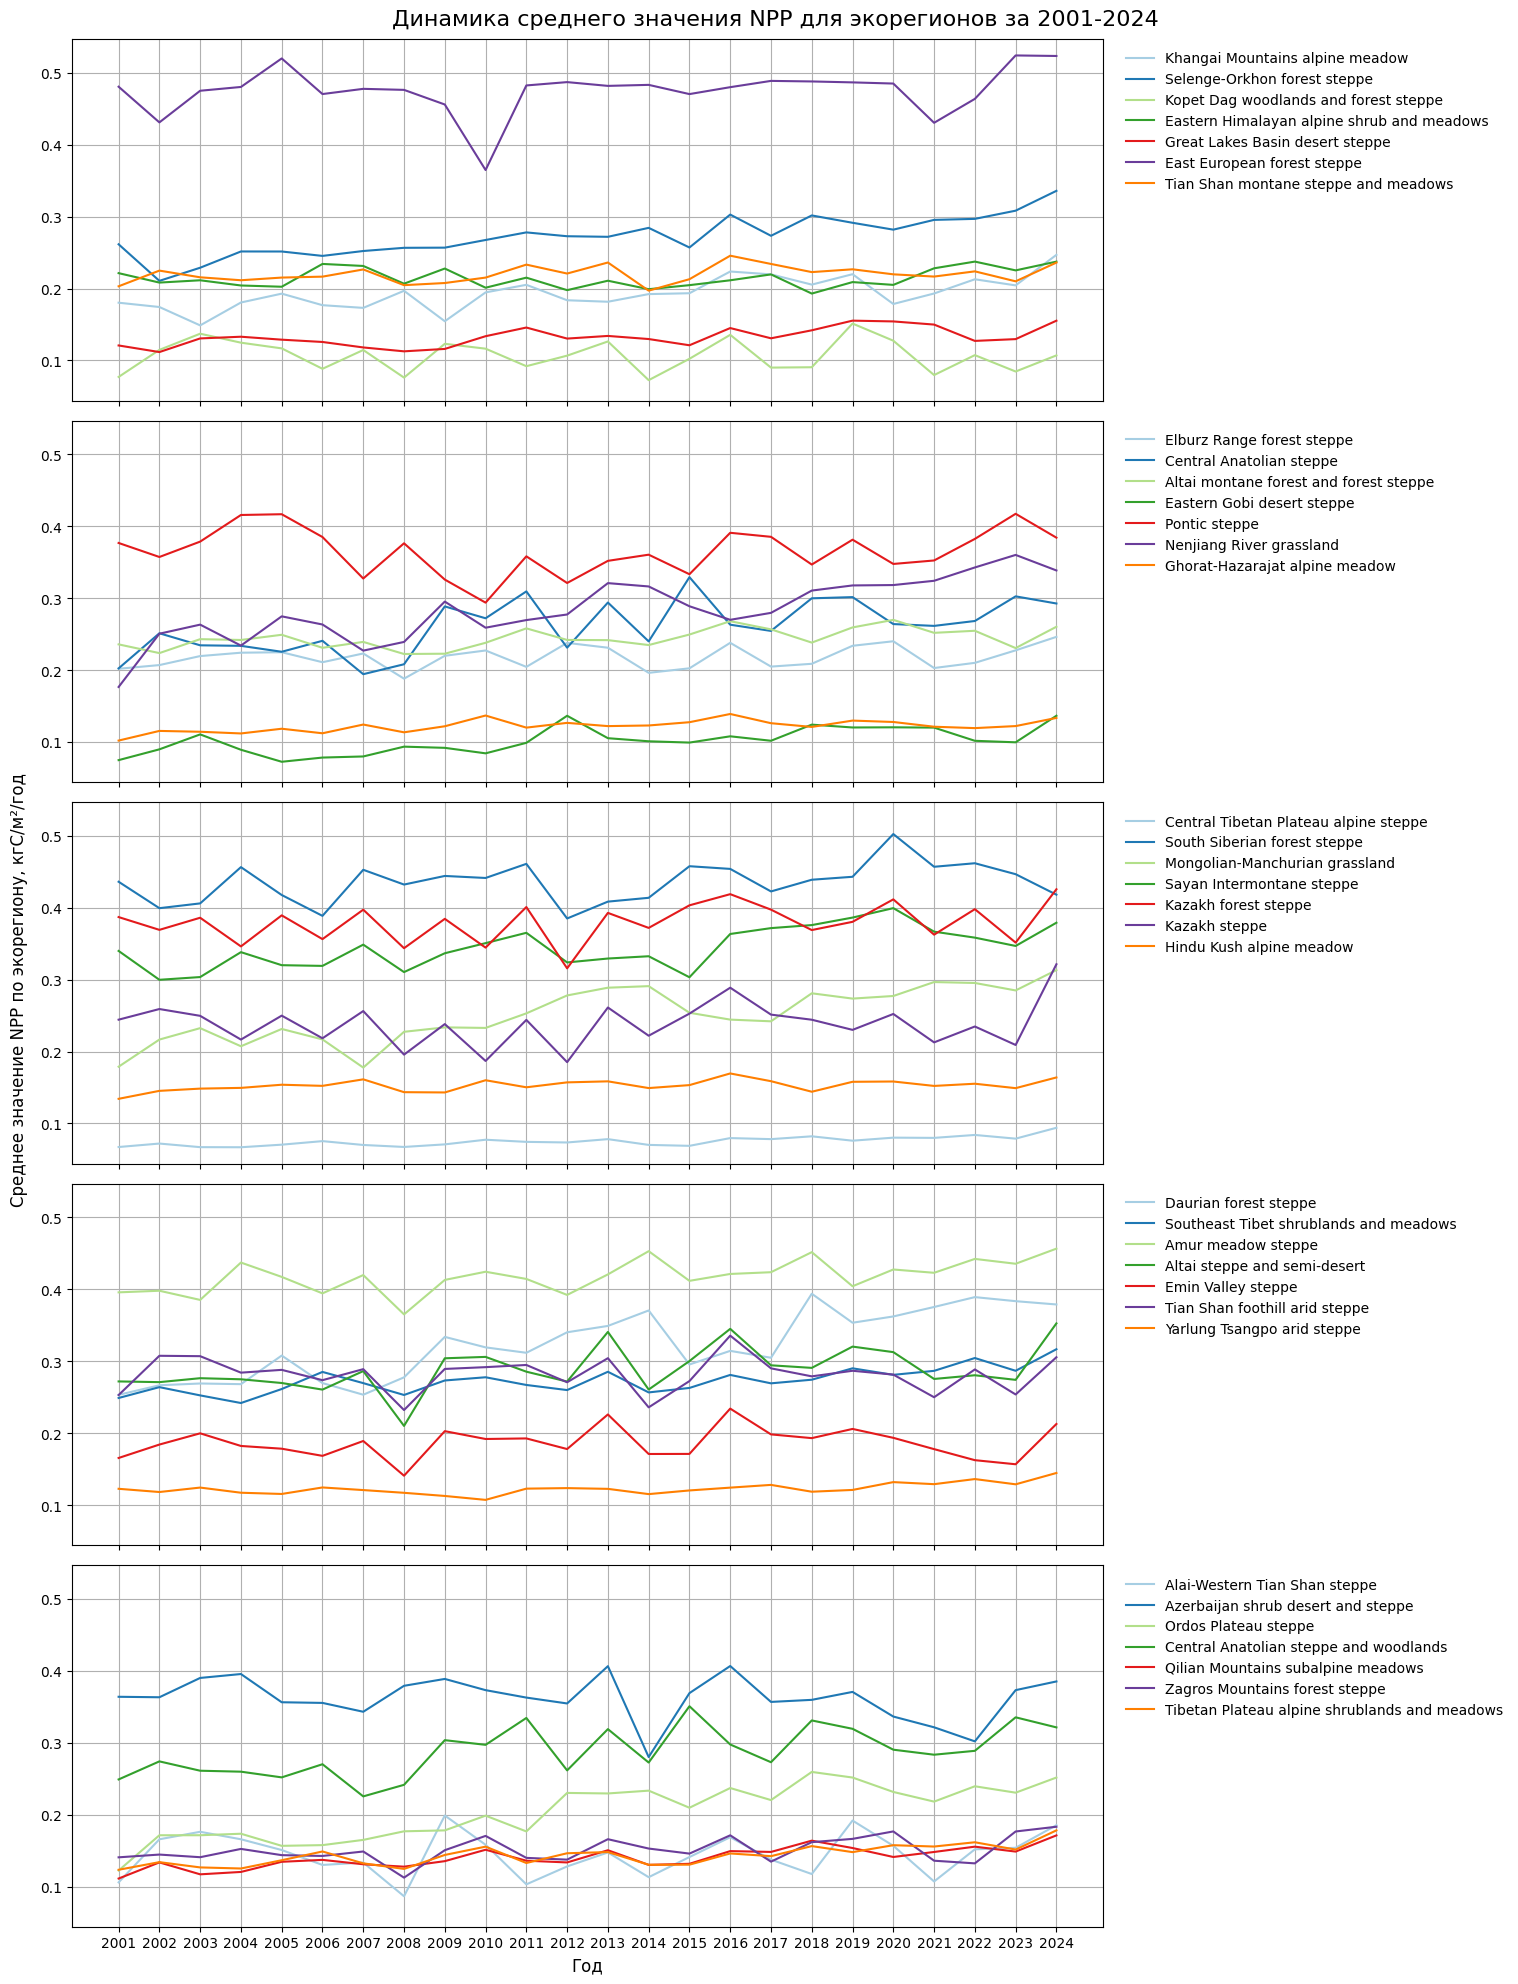

In [ ]:
# visualization of the dynamics of the mean NPP value for ecoregions for 2001-2024
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.ravel()

mean_columns = [f'MEAN_{year}' for year in range(2001, 2025)]
zonal_stat_mean = zonal_stat[mean_columns]
zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']
unique_eco_names = zonal_stat_mean['ECO_NAME'].unique()
num_plots = len(unique_eco_names)
plots_per_subplot = num_plots // 5 + (num_plots % 5 > 0)

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#E31A1C', '#6A3D9A', '#FF7F00', '#6A3D9A']

for i, ax in enumerate(axs):
    start_idx = i * plots_per_subplot
    end_idx = min((i + 1) * plots_per_subplot, num_plots)
    eco_names_subset = unique_eco_names[start_idx:end_idx]
    legend_data = {}

    for j, er in enumerate(eco_names_subset):
        data = zonal_stat_mean[zonal_stat_mean['ECO_NAME'] == er]
        legend_data[er], = ax.plot(range(2001, 2025), data.iloc[0, :-1], label=er, color=colors[j])

    ax.grid(True)
    if i == 4:  
        ax.set_xlabel('Год', fontsize=12)
        ax.set_xticks(range(2001, 2025))
    else:
        ax.set_xticks([])

    ax.legend(legend_data.values(), legend_data.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle('Динамика среднего значения NPP для экорегионов за 2001-2024', fontsize=16, x=0.5, y=0.99)
fig.text(-0.01, 0.5, 'Среднее значение NPP по экорегиону, кгC/м²/год', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

In [ ]:
# plot with all labels in RUS
zonal_stat = pd.read_excel('E:\diplom\zonal_stat_combined.xlsx', index_col='ZONE_CODE')
zonal_stat.head(5)

,ECO_NAME,ECO_NAME_RUS,MIN_2001,MAX_2001,MEAN_2001,STD_2001,MEDIAN_2001,PCT5_2001,PCT95_2001,MIN_2002,...,MEDIAN_2023,PCT5_2023,PCT95_2023,MIN_2024,MAX_2024,MEAN_2024,STD_2024,MEDIAN_2024,PCT5_2024,PCT95_2024
ZONE_CODE,,,,,,,,,,,,,,,,,,,,,
1,Khangai Mountains alpine meadow,Альпийские луга Хангайских гор,0.0205,0.4831,0.180304,0.054590,0.1785,0.0950,0.2724,0.0179,...,0.2013,0.1043,0.3134,0.0338,0.6586,0.246838,0.069527,0.2435,0.1358,0.3626
2,Selenge-Orkhon forest steppe,Селенгинско-Орхонские лесостепи,0.0259,0.6557,0.261548,0.087541,0.2544,0.1325,0.4217,0.0234,...,0.2958,0.1508,0.5203,0.0313,0.7643,0.335870,0.107513,0.3278,0.1775,0.5173
3,Kopet Dag woodlands and forest steppe,Копетдагские леса и лесостепи,0.0001,0.3917,0.077079,0.037758,0.0703,0.0312,0.1434,0.0001,...,0.0719,0.0333,0.1710,0.0010,0.5278,0.107015,0.057150,0.0931,0.0416,0.2103
4,Eastern Himalayan alpine shrub and meadows,Восточногималайские альпийские луга и кустарники,0.0001,1.9256,0.221412,0.273761,0.1079,0.0286,0.9002,0.0001,...,0.1196,0.0310,0.8547,0.0008,1.8737,0.237442,0.251233,0.1387,0.0377,0.8216
5,Great Lakes Basin desert steppe,Пустынные степи бассейна Великих озер,0.0132,0.6841,0.120841,0.083049,0.0917,0.0483,0.3058,0.0157,...,0.0994,0.0536,0.3112,0.0165,0.7111,0.155284,0.095780,0.1207,0.0626,0.3685


C:\Users\varva\AppData\Local\Temp\ipykernel_22112\4147876018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_stat_mean['ECO_NAME_RUS'] = zonal_stat['ECO_NAME_RUS']


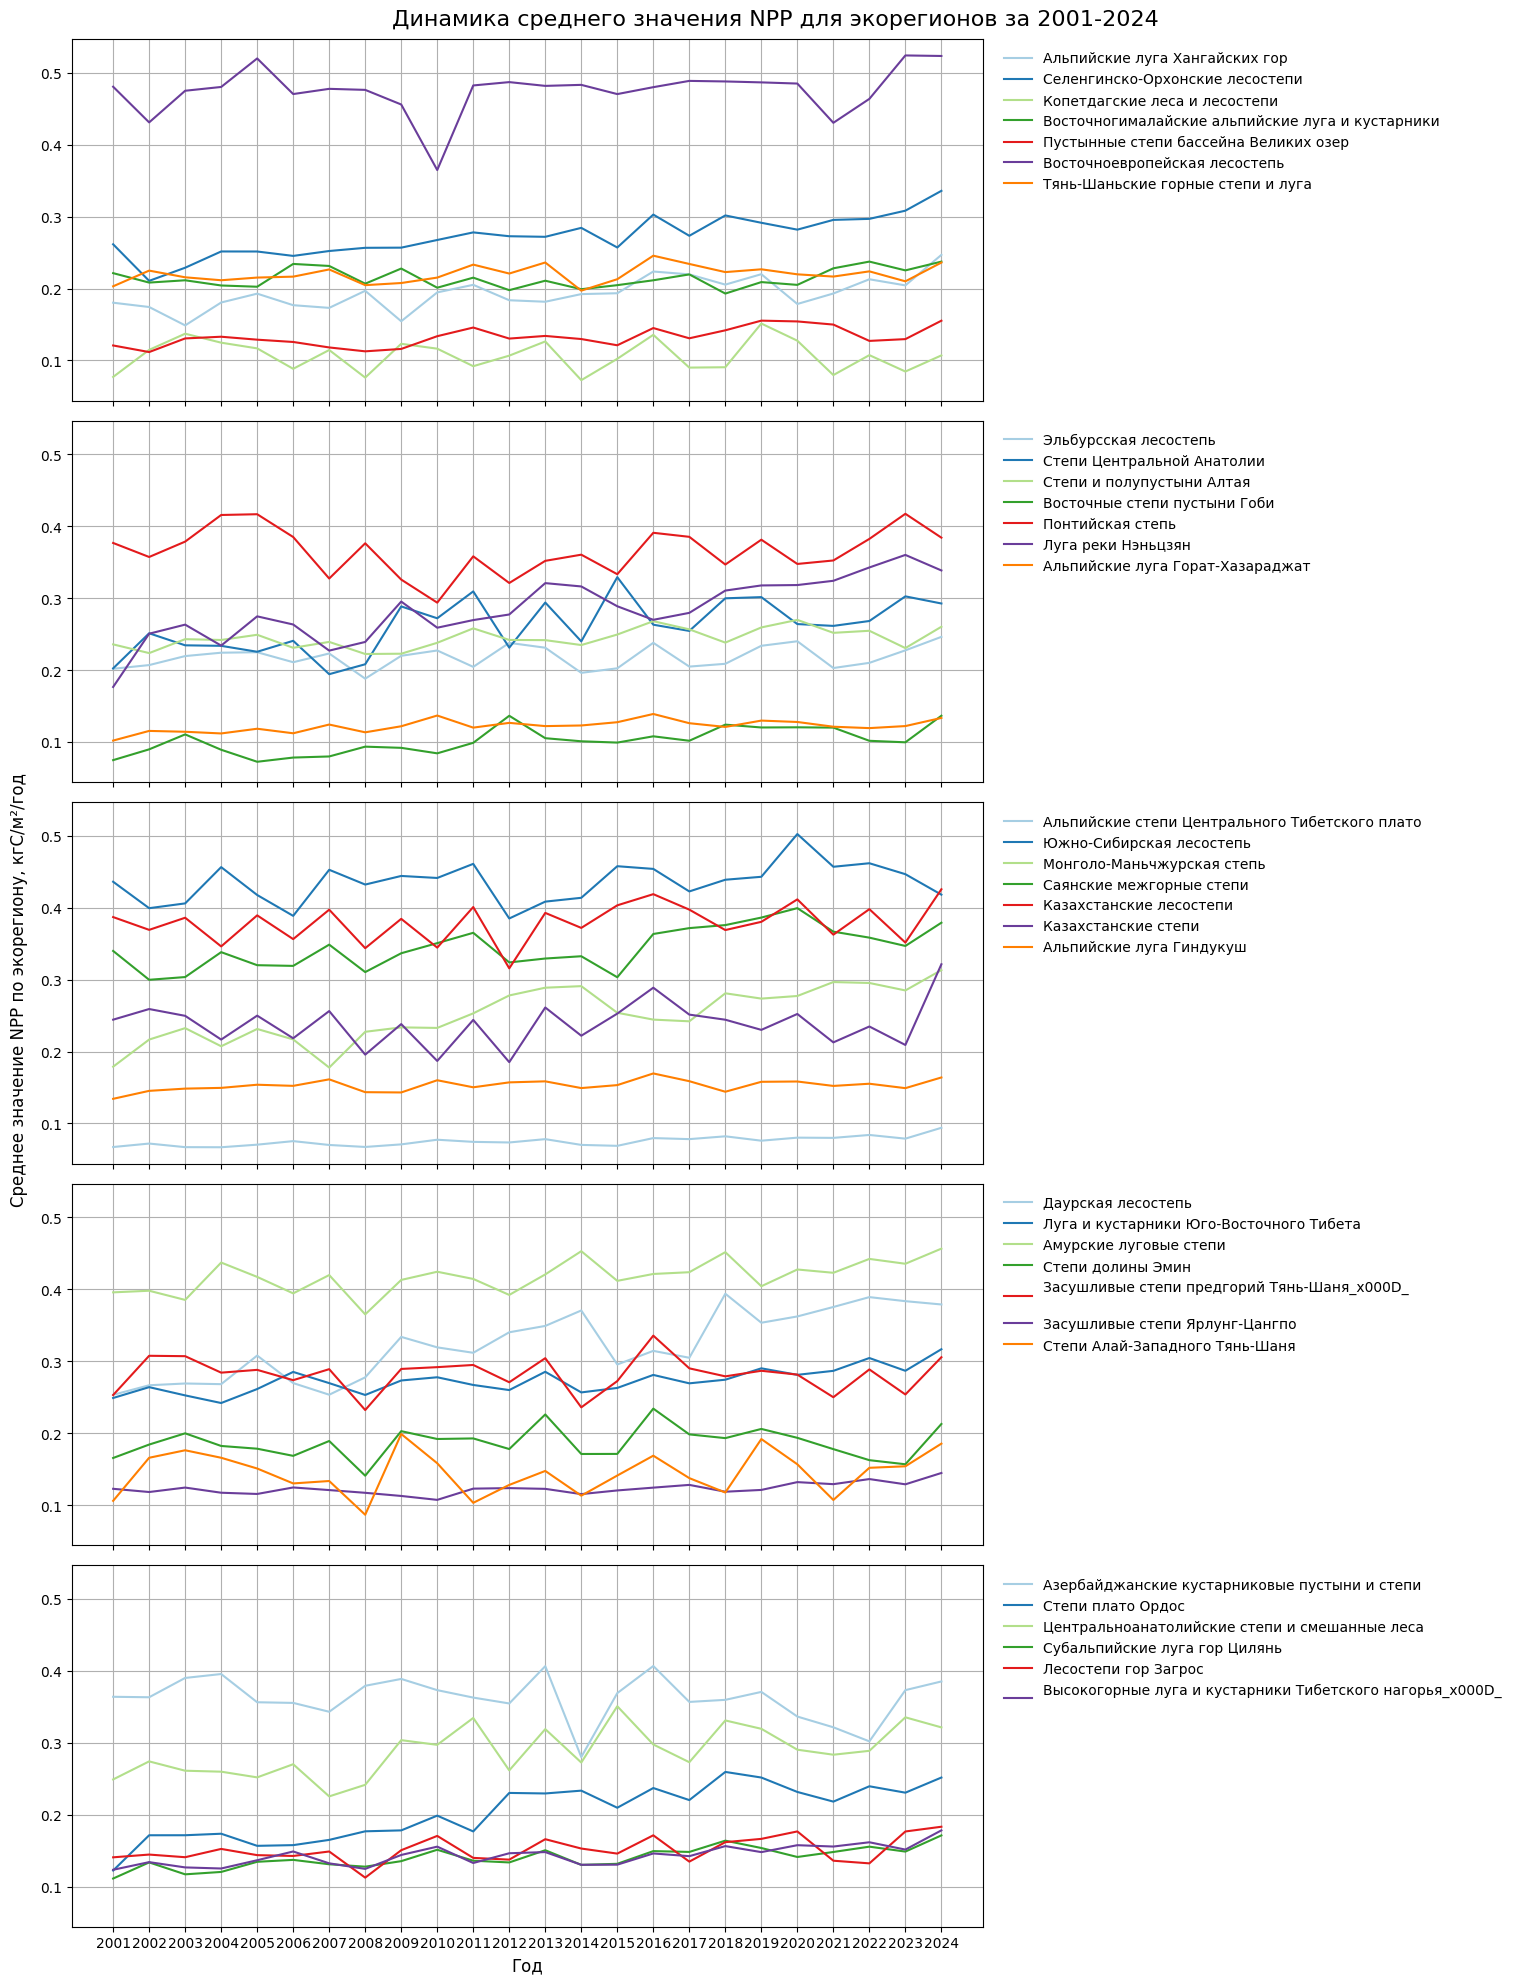

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.ravel()

mean_columns = [f'MEAN_{year}' for year in range(2001, 2025)]
zonal_stat_mean = zonal_stat[mean_columns]
zonal_stat_mean['ECO_NAME_RUS'] = zonal_stat['ECO_NAME_RUS']
unique_eco_names = zonal_stat_mean['ECO_NAME_RUS'].unique()
num_plots = len(unique_eco_names)
plots_per_subplot = num_plots // 5 + (num_plots % 5 > 0)

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#E31A1C', '#6A3D9A', '#FF7F00', '#6A3D9A']

for i, ax in enumerate(axs):
    start_idx = i * plots_per_subplot
    end_idx = min((i + 1) * plots_per_subplot, num_plots)
    eco_names_subset = unique_eco_names[start_idx:end_idx]
    legend_data = {}

    for j, er in enumerate(eco_names_subset):
        data = zonal_stat_mean[zonal_stat_mean['ECO_NAME_RUS'] == er]
        legend_data[er], = ax.plot(range(2001, 2025), data.iloc[0, :-1], label=er, color=colors[j])

    ax.grid(True)
    if i == 4:  
        ax.set_xlabel('Год', fontsize=12)
        ax.set_xticks(range(2001, 2025))
    else:
        ax.set_xticks([])

    ax.legend(legend_data.values(), legend_data.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle('Динамика среднего значения NPP для экорегионов за 2001-2024', fontsize=16, x=0.5, y=0.99)
fig.text(-0.01, 0.5, 'Среднее значение NPP по экорегиону, кгC/м²/год', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

Same for the NEE data in NetCDF

In [ ]:
# zonal statistics 
sheets = pd.read_excel('E:\GCAS\gcas_zonal_stat.xls', sheet_name=None, index_col='ZONE_CODE')
columns = ['ECO_NAME', 'MIN', 'MAX', 'MEAN', 'STD', 'MEDIAN', 'PCT5', 'PCT95']
years = list(range(2010, 2020))
zonal_stat = None

for i, (sheet_name, df) in enumerate(sheets.items()):
    year = years[i]
    df_selected = df[columns]

    if i == 0:
        df_renamed = df_selected.rename(columns={col: f"{col}_{year}" for col in df_selected.columns if col != 'ECO_NAME'})
    else:
        df_renamed = df_selected.drop(columns='ECO_NAME', errors='ignore').rename(columns={col: f"{col}_{year}" for col in df_selected.columns})

    if zonal_stat is None:
        zonal_stat = df_renamed
    else:
        zonal_stat = pd.concat([zonal_stat, df_renamed], axis=1)

print('zonal stat is combined')

zonal stat is combined


In [4]:
zonal_stat.to_excel('E:\GCAS\gcas_zonal_stat_combined.xlsx')
zonal_stat.head()

,ECO_NAME,MIN_2010,MAX_2010,MEAN_2010,STD_2010,MEDIAN_2010,PCT5_2010,PCT95_2010,MIN_2011,MAX_2011,...,MEDIAN_2018,PCT5_2018,PCT95_2018,MIN_2019,MAX_2019,MEAN_2019,STD_2019,MEDIAN_2019,PCT5_2019,PCT95_2019
ZONE_CODE,,,,,,,,,,,,,,,,,,,,,
1,Khangai Mountains alpine meadow,-33.082447,-21.101957,-27.302289,4.545320,-28.229435,-32.686932,-21.243986,-44.187740,-13.708731,...,-17.350380,-23.662035,-4.604546,-38.171169,-21.129156,-25.928370,5.946212,-23.008314,-35.682983,-21.355577
2,Selenge-Orkhon forest steppe,-55.302055,15.000436,-19.566662,20.453570,-22.804268,-47.321659,13.976857,-40.183472,23.964233,...,-29.510715,-78.464164,0.041993,-66.215408,43.556004,-17.166521,23.400877,-19.296274,-46.029902,17.461306
3,Kopet Dag woodlands and forest steppe,-9.848472,-1.906319,-6.933555,3.007523,-7.989715,-9.614655,-2.773831,-0.191928,5.326049,...,1.014334,-3.035860,3.785547,-33.386238,-16.391447,-23.943684,6.138744,-22.998525,-32.004034,-17.206555
4,Eastern Himalayan alpine shrub and meadows,-45.033794,-6.465094,-17.982049,14.165008,-12.071593,-39.733883,-6.733180,-127.946335,-46.725555,...,-6.593236,-27.589496,-1.004750,-68.851219,24.890461,-2.931240,35.941423,21.656452,-57.903967,24.264981
5,Great Lakes Basin desert steppe,-42.155003,0.237811,-11.710217,12.713203,-5.819996,-32.478490,0.237811,-23.824877,0.095501,...,-2.902229,-27.535859,2.495255,-58.402889,0.390194,-10.280420,14.739306,-5.313618,-39.496154,-0.111813


C:\Users\varva\AppData\Local\Temp\ipykernel_17708\1416521495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']


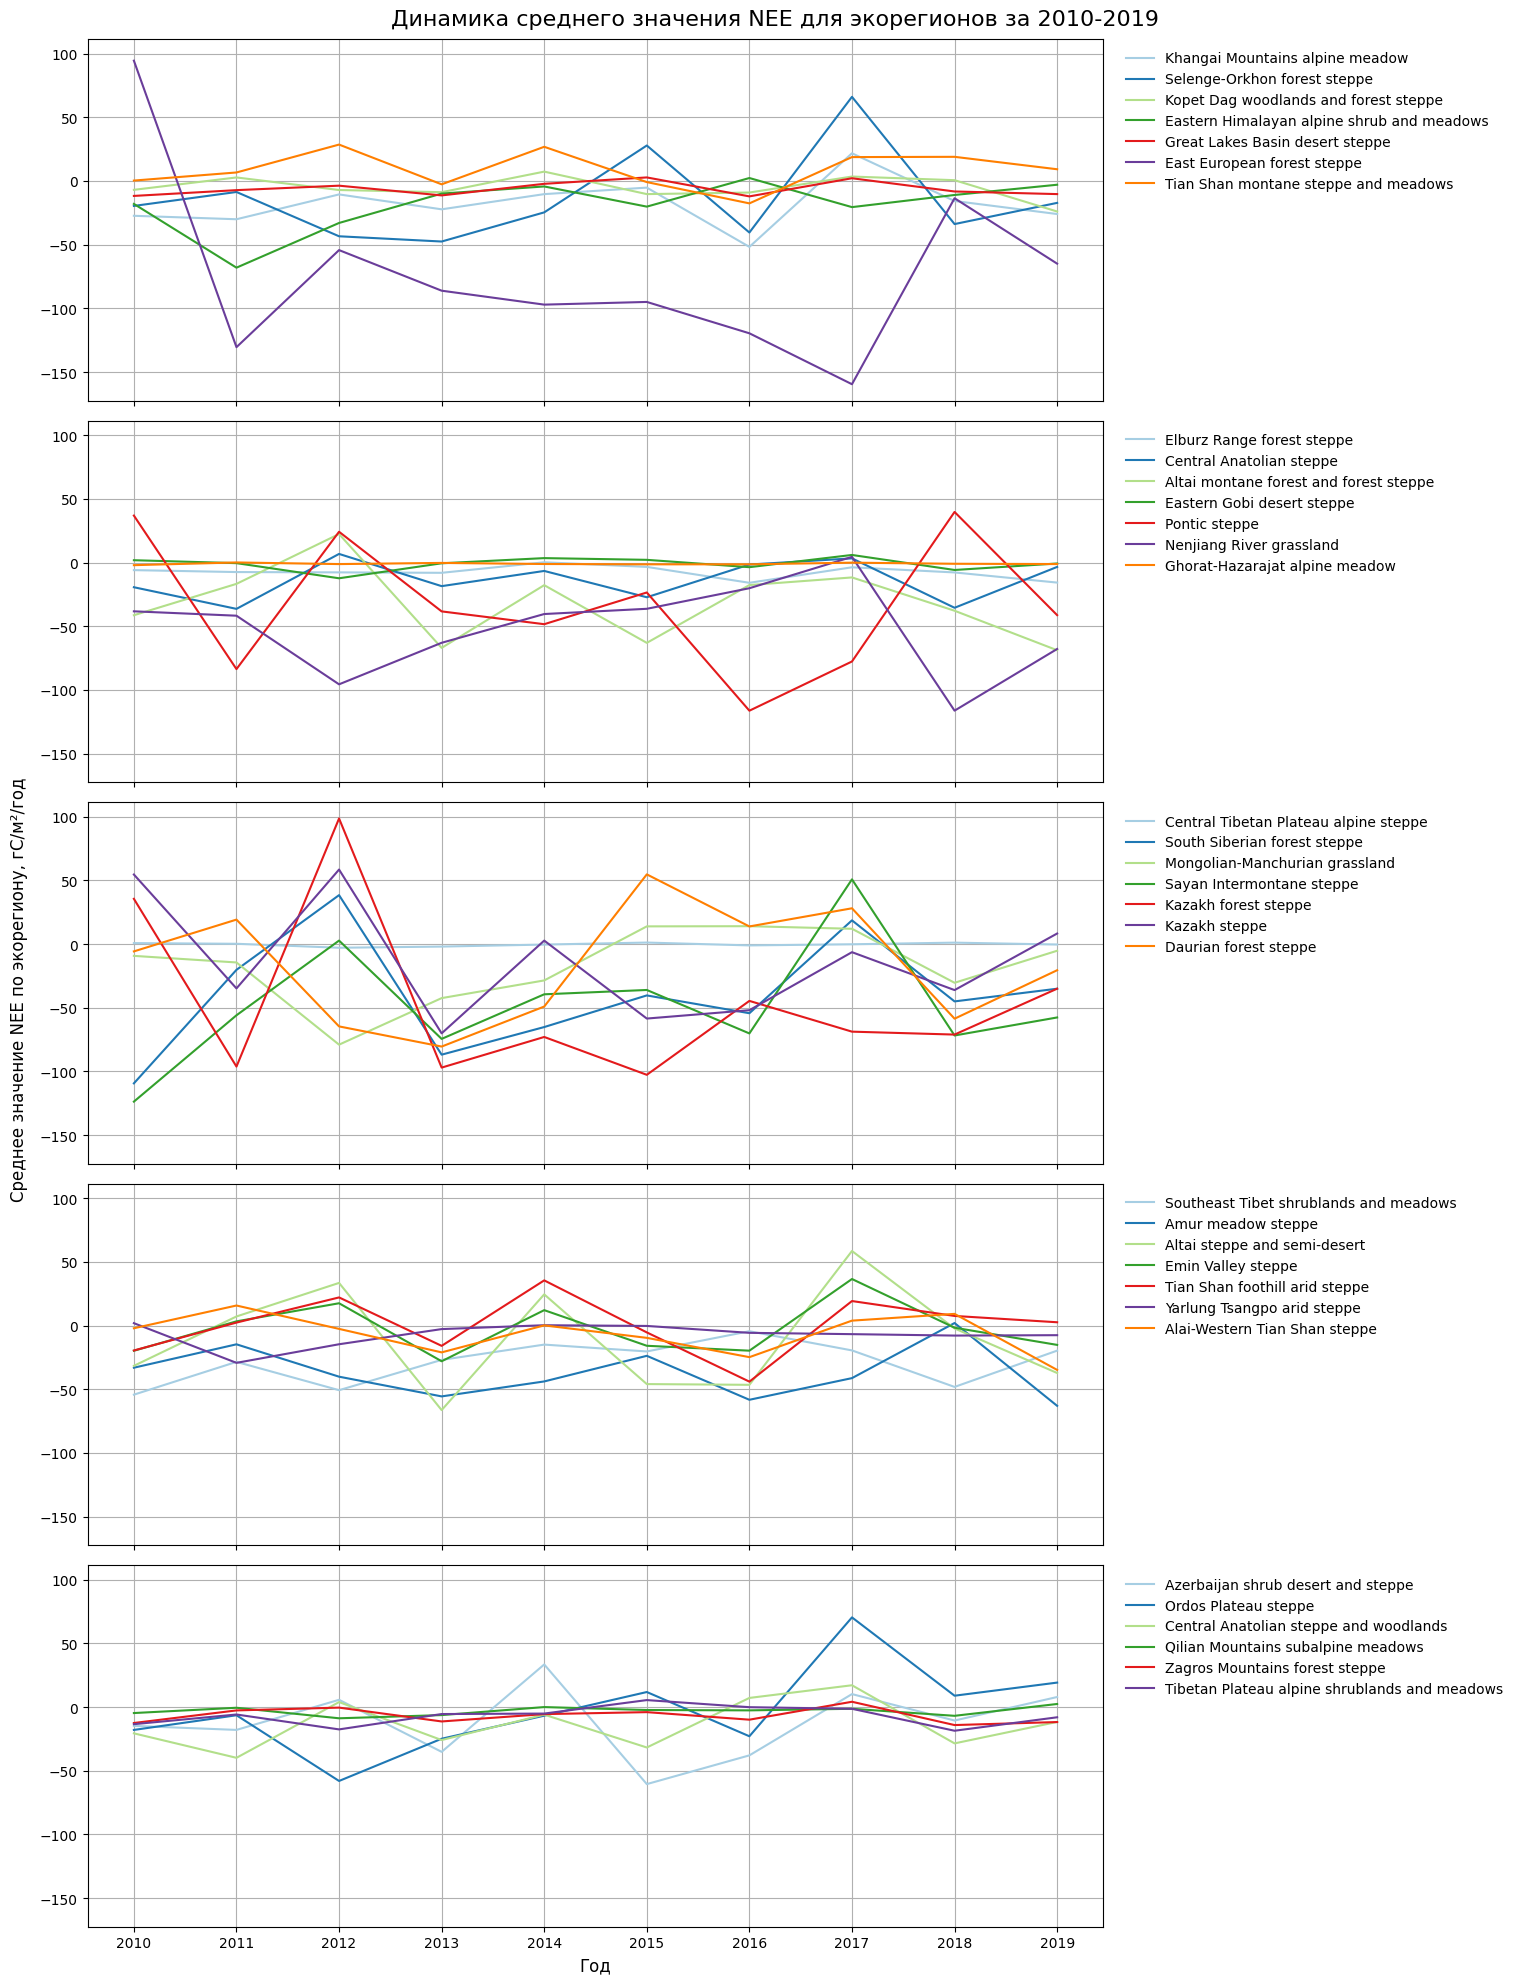

In [ ]:
# visualization of the dynamics of the mean NEE value for ecoregions for 2010-2019
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.ravel()

mean_columns = [f'MEAN_{year}' for year in range(2010, 2020)]
zonal_stat_mean = zonal_stat[mean_columns]
zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']
unique_eco_names = zonal_stat_mean['ECO_NAME'].unique()
num_plots = len(unique_eco_names)
plots_per_subplot = num_plots // 5 + (num_plots % 5 > 0)

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#E31A1C', '#6A3D9A', '#FF7F00', '#6A3D9A']

for i, ax in enumerate(axs):
    start_idx = i * plots_per_subplot
    end_idx = min((i + 1) * plots_per_subplot, num_plots)
    eco_names_subset = unique_eco_names[start_idx:end_idx]
    legend_data = {}

    for j, er in enumerate(eco_names_subset):
        data = zonal_stat_mean[zonal_stat_mean['ECO_NAME'] == er]
        legend_data[er], = ax.plot(range(2010, 2020), data.iloc[0, :-1], label=er, color=colors[j])

    ax.grid(True)
    if i == 4:  
        ax.set_xlabel('Год', fontsize=12)
        ax.set_xticks(range(2010, 2020))
    else:
        ax.set_xticks([])

    ax.legend(legend_data.values(), legend_data.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle('Динамика среднего значения NEE для экорегионов за 2010-2019', fontsize=16, x=0.5, y=0.99)
fig.text(-0.01, 0.5, 'Среднее значение NEE по экорегиону, гC/м²/год', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

In [ ]:
# plot with all labels in RUS
zonal_stat = pd.read_excel('E:\diplom\GCAS\gcas_zonal_stat_combined.xlsx', index_col='ZONE_CODE')
zonal_stat.head(5)

,ECO_NAME,ECO_NAME_RUS,MIN_2010,MAX_2010,MEAN_2010,STD_2010,MEDIAN_2010,PCT5_2010,PCT95_2010,MIN_2011,...,MEDIAN_2018,PCT5_2018,PCT95_2018,MIN_2019,MAX_2019,MEAN_2019,STD_2019,MEDIAN_2019,PCT5_2019,PCT95_2019
ZONE_CODE,,,,,,,,,,,,,,,,,,,,,
1.0,Khangai Mountains alpine meadow,Альпийские луга Хангайских гор,-33.082447,-21.101957,-27.302289,4.545320,-28.229435,-32.686932,-21.243986,-44.187740,...,-17.350380,-23.662035,-4.604546,-38.171169,-21.129156,-25.928370,5.946212,-23.008314,-35.682983,-21.355577
2.0,Selenge-Orkhon forest steppe,Селенгинско-Орхонские лесостепи,-55.302055,15.000436,-19.566662,20.453570,-22.804268,-47.321659,13.976857,-40.183472,...,-29.510715,-78.464164,0.041993,-66.215408,43.556004,-17.166521,23.400877,-19.296274,-46.029902,17.461306
3.0,Kopet Dag woodlands and forest steppe,Копетдагские леса и лесостепи,-9.848472,-1.906319,-6.933555,3.007523,-7.989715,-9.614655,-2.773831,-0.191928,...,1.014334,-3.035860,3.785547,-33.386238,-16.391447,-23.943684,6.138744,-22.998525,-32.004034,-17.206555
4.0,Eastern Himalayan alpine shrub and meadows,Восточногималайские альпийские луга и кустарники,-45.033794,-6.465094,-17.982049,14.165008,-12.071593,-39.733883,-6.733180,-127.946335,...,-6.593236,-27.589496,-1.004750,-68.851219,24.890461,-2.931240,35.941423,21.656452,-57.903967,24.264981
5.0,Great Lakes Basin desert steppe,Пустынные степи бассейна Великих озер,-42.155003,0.237811,-11.710217,12.713203,-5.819996,-32.478490,0.237811,-23.824877,...,-2.902229,-27.535859,2.495255,-58.402889,0.390194,-10.280420,14.739306,-5.313618,-39.496154,-0.111813


C:\Users\varva\AppData\Local\Temp\ipykernel_22112\1074502224.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_stat_mean['ECO_NAME_RUS'] = zonal_stat['ECO_NAME_RUS']


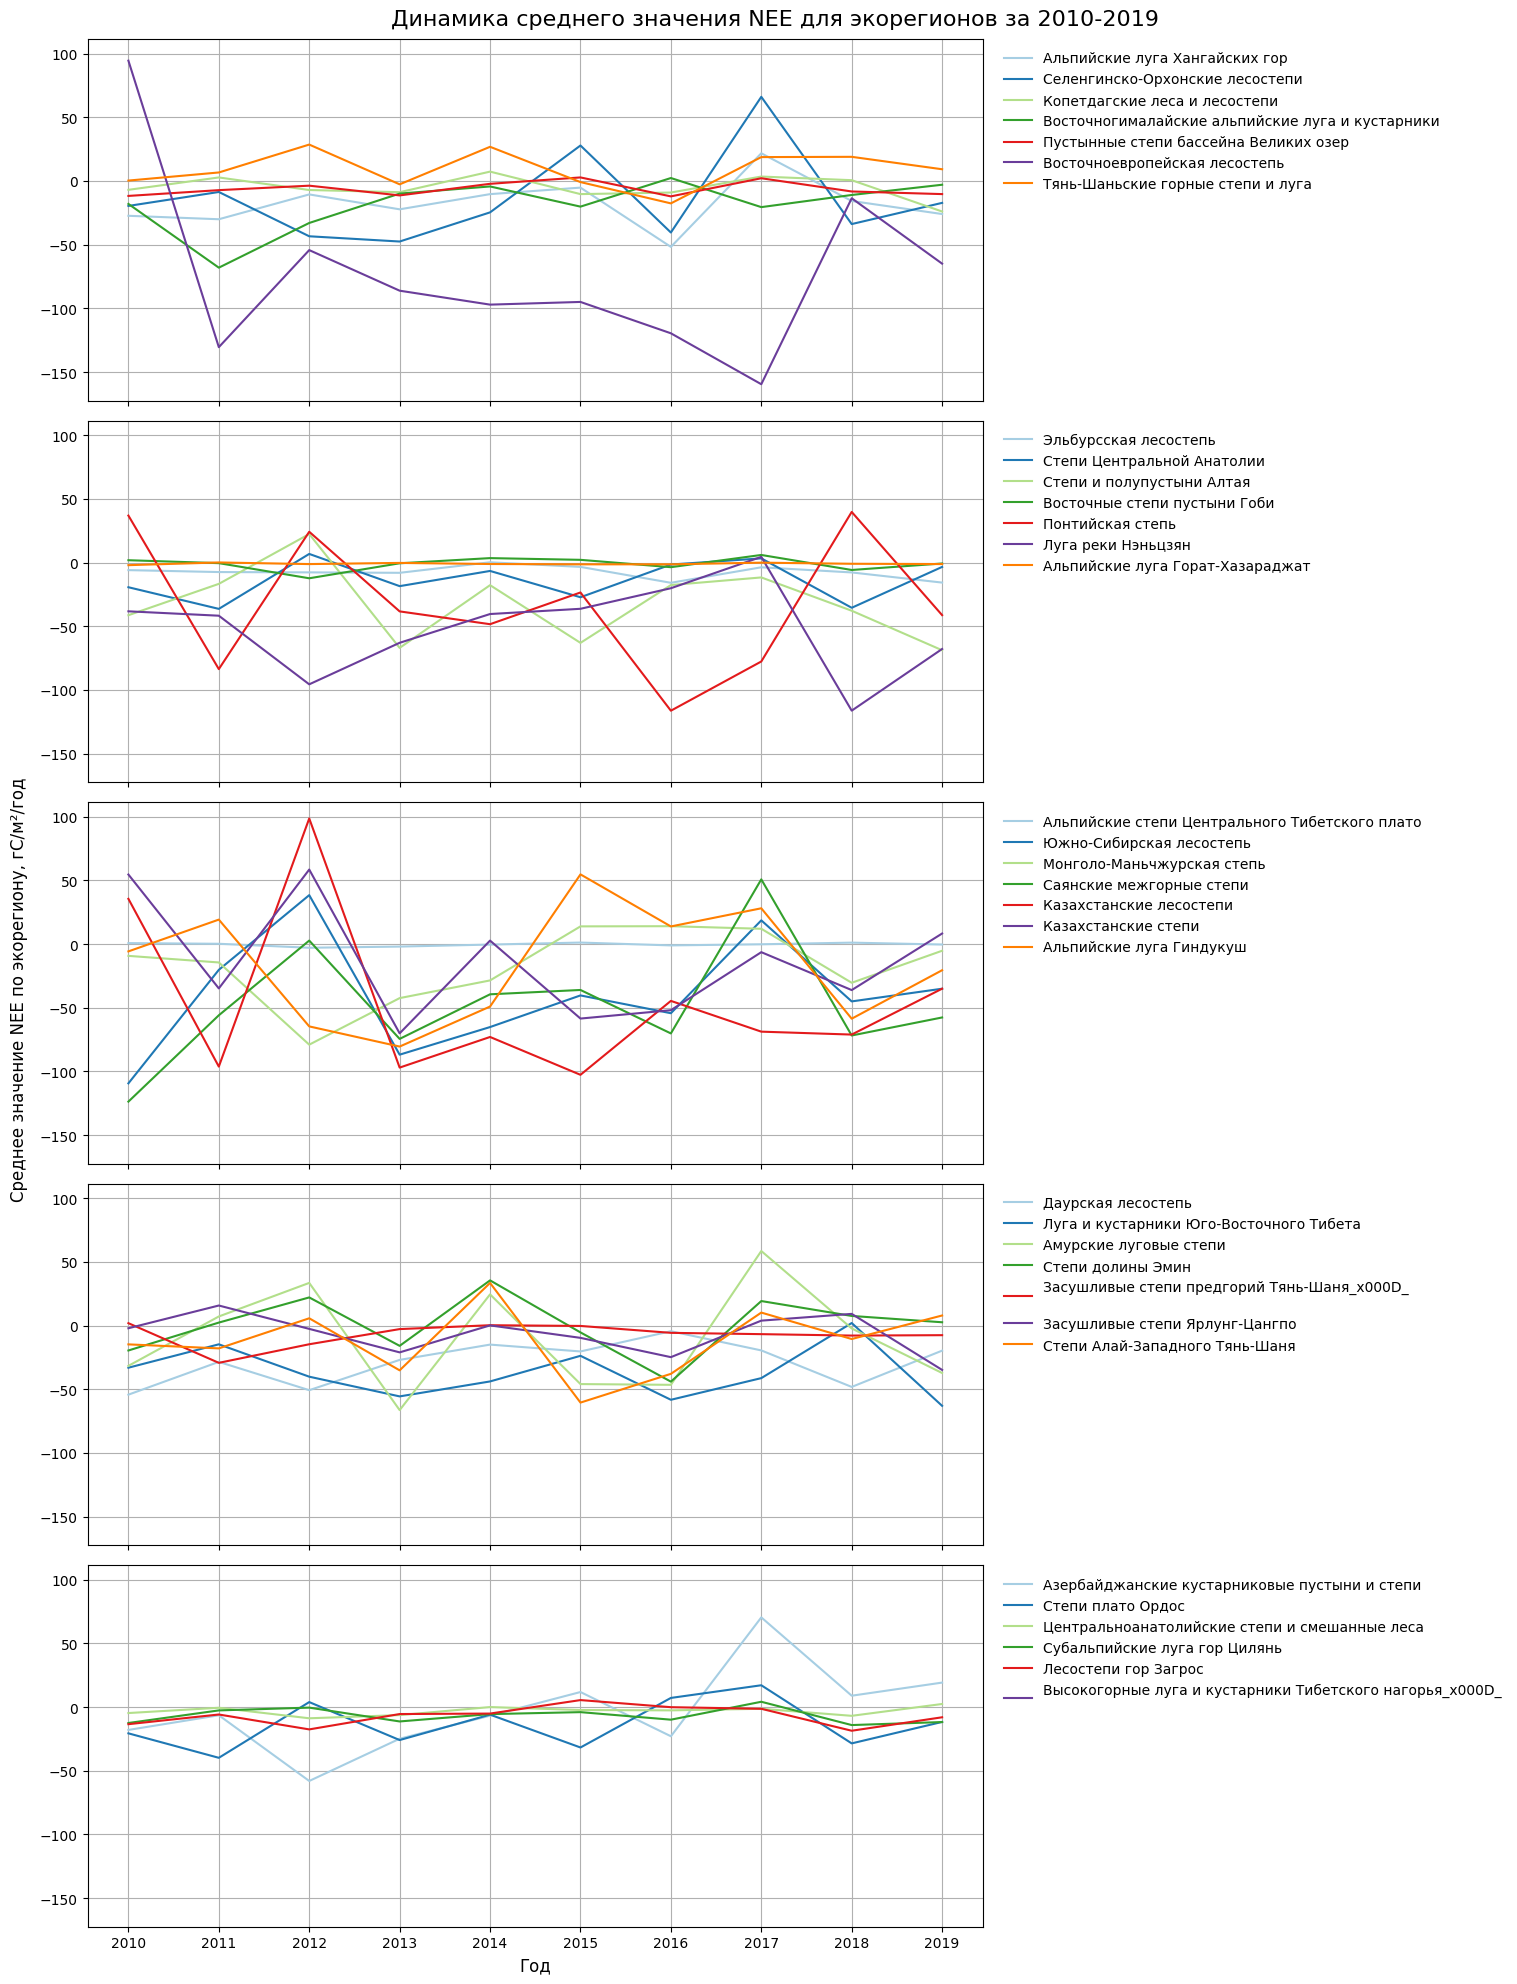

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.ravel()

mean_columns = [f'MEAN_{year}' for year in range(2010, 2020)]
zonal_stat_mean = zonal_stat[mean_columns]
zonal_stat_mean['ECO_NAME_RUS'] = zonal_stat['ECO_NAME_RUS']
unique_eco_names = zonal_stat_mean['ECO_NAME_RUS'].unique()
num_plots = len(unique_eco_names)
plots_per_subplot = num_plots // 5 + (num_plots % 5 > 0)

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#E31A1C', '#6A3D9A', '#FF7F00', '#6A3D9A']

for i, ax in enumerate(axs):
    start_idx = i * plots_per_subplot
    end_idx = min((i + 1) * plots_per_subplot, num_plots)
    eco_names_subset = unique_eco_names[start_idx:end_idx]
    legend_data = {}

    for j, er in enumerate(eco_names_subset):
        data = zonal_stat_mean[zonal_stat_mean['ECO_NAME_RUS'] == er]
        legend_data[er], = ax.plot(range(2010, 2020), data.iloc[0, :-1], label=er, color=colors[j])

    ax.grid(True)
    if i == 4:  
        ax.set_xlabel('Год', fontsize=12)
        ax.set_xticks(range(2010, 2020))
    else:
        ax.set_xticks([])

    ax.legend(legend_data.values(), legend_data.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle('Динамика среднего значения NEE для экорегионов за 2010-2019', fontsize=16, x=0.5, y=0.99)
fig.text(-0.01, 0.5, 'Среднее значение NEE по экорегиону, гC/м²/год', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()